# 模型
![](img/transformer.png)

**Source Code**:   https://www.tensorflow.org/tutorials/text/transformer

In [146]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras.layers as layers
import time
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


# 1. 数据预处理
+ tensorflow提供的葡萄牙语翻译英语数据集；

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [167]:
# 数据集基本信息
metadata

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)

In [171]:
# 查看数据
train = tfds.as_numpy(train_examples)
next(train)

(b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .',
 b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .')

In [172]:
# 生成两种语言的词表
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

*测试* 

**Encoding is fully invertible because all out-of-vocab wordpieces are byte-encoded.**

（SubwordTextEncoder是可逆的。如果单词不在词典中，则分词器（tokenizer）通过将单词分解为子词（如字母）来对字符串进行编码。）

In [173]:
sample_string = 'Transformer is awesome!'
tokenized_string = tokenizer_en.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7864]


In [174]:
original_string = tokenizer_en.decode(tokenized_string)
print('The original string is {}'.format(original_string))

The original string is Transformer is awesome!


In [175]:
assert original_string == sample_string

In [176]:
for ts in tokenized_string:
  print('{} ------> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ------> T
1248 ------> ran
7946 ------> s
7194 ------> former 
13 ------> is 
2799 ------> awesome
7864 ------> !


### 将开始和结束标记添加到训练语料中


开始标记：词表大小  
结束标记：词表大小+1

In [4]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size + 1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size + 1]
    return lang1, lang2

In [178]:
# 为了使示例较小且相对较快，删除长度大于40个标记的样本。
MAX_LENGTH = 40

In [6]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                          tf.size(y) <= max_length)

In [179]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])
    return result_pt, result_en

In [180]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [184]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)


# 数据集缓存
train_dataset = train_dataset.cache()
# 打乱数据集，用0填充
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE,
                                                                padded_shapes=([None],[None]),
                                                                padding_values=(tf.constant(0, dtype=tf.int64),
                                                                                tf.constant(0, dtype=tf.int64)))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE,
                                                                 padded_shapes=([None],[None]),
                                                                 padding_values=(tf.constant(0, dtype=tf.int64),
                                                                                 tf.constant(0, dtype=tf.int64)))

训练语料转换成单词表索引向量

In [185]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

# 2.位置编码 （Positional Encoding）


+ 为模型提供单词在句子中的位置信息；
+ 公式：
$$
\text{PE}(\text{pos}, 2i) = \sin(\frac{\text{pos}}{10000^{2i / d_{model}}})     
$$

$$
\text{PE}(\text{pos}, 2i+1) = \cos(\frac{\text{pos}}{10000^{2i / d_{model}}})
$$


In [14]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

In [17]:
def positional_encoding(postion, d_model):
    angle_rads = get_angles(np.arange(postion)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

*测试*

(1, 50, 128)


/Users/liling/anaconda3/envs/UdaCourse/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/liling/anaconda3/envs/UdaCourse/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


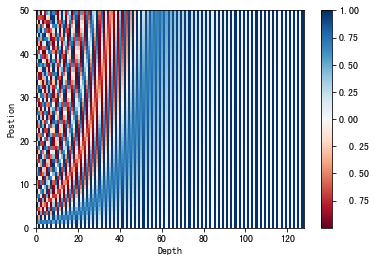

In [18]:
pos_encoding = positional_encoding(50, 128)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Postion')
plt.colorbar()
plt.show()

# 3.遮挡（Masking）
+ 遮挡序列中的填充标记（pad tokens），保证模型不将填充作为输入；

In [186]:
def create_padding_mask(seq):
    # 填充值 0 出现的位置：在这些位置 mask 输出 1，否则输出 0
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

*测试*

In [20]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

### Look-ahead mask:
+ 遮挡一个序列中的后续标记（future tokens)，例如要预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。

In [21]:
def create_look_ahead_mask(size):
    return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

*测试*

In [22]:
x = tf.random.uniform((1, 3))
print(x)
create_look_ahead_mask(x.shape[1])

tf.Tensor([[0.72421587 0.53976834 0.38579965]], shape=(1, 3), dtype=float32)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# 4. Scaled Dot-Product Attention
$$
\text{Attenion}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}}) V
$$

In [187]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    参数:
    q: (..., seq_len_q, depth)
    k: (..., seq_len_k, depth)
    v: (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。
    
    返回值:
        输出，注意力权重
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True) 
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    
    if mask is not None:
        #-1e9 接近负无穷，softmax输入负无穷为接近0，完成遮挡的目标
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

*测试*

In [24]:
np.set_printoptions(suppress=True)

In [25]:
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)    # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

In [26]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('>>>>> Attention weights are:')
    print(temp_attn)
    print('>>>>> Output is:')
    print(temp_out)

In [27]:
print_out(temp_q, temp_k, temp_v)

>>>>> Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
>>>>> Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [37]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

>>>>> Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
>>>>> Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [38]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

>>>>> Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
>>>>> Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


# 5. Multi-head Attention
+ 多个头扩展了模型专注于不同位置的能力。

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        """
        拆分最后一个维度并转置
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        return output, attention_weights

*测试*

In [29]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# 6. Feed Forward Network
+ 由两个线性变换组成，中间有一个 ReLU 激活函数，对应到公式的形式为：

$$
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

In [30]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'),
                                tf.keras.layers.Dense(d_model)])

*测试*

In [31]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

# 7. Encoder Layer  & Decoder Layer
+ Add & Norm: 残差连接有助于避免梯度消失；归一化是在 d_model（最后一个）维度完成的。


In [102]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + attn_output)
        
        return out2

*测试*

In [103]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [72]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout1(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2
        

*测试*

In [75]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

# 8. Encoder & Decoder

In [132]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, max_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_position_encoding, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

*测试*

In [133]:
sample_encoder = Encoder(num_layers=2, 
                         d_model=512, 
                         num_heads=8,
                         dff=2048, 
                         input_vocab_size=8500,
                         max_position_encoding=10000)
sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), training=False, mask=None)
print(sample_encoder_output.shape)

(64, 62, 512)


In [35]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads,  dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        return x, attention_weights

*测试*

In [71]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# 9. Transformer

In [126]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask,
                                                     dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

*测试*

In [134]:
sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8,
                                 dff=2048, input_vocab_size=8500, 
                                 target_vocab_size=8000, pe_input=10000, 
                                 pe_target=6000)
temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)
fn_out.shape

TensorShape([64, 26, 8000])

# 10. Optimizer

In [37]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

$$
    \text{lrate} = \text{d_model}^{-0.5} * \min(\text{step_num} ^{-0.5}, \text{step_num} * \text{warmup_steps} ^{-1.5})
$$

In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

*测试*

Text(0.5, 0, 'Train Step')

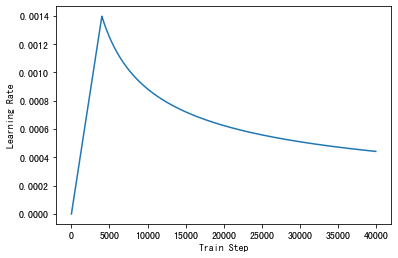

In [46]:
temp_learning_rate_schedule = CustomSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# 11. Loss

In [40]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [41]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [42]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# 12. Train

In [144]:
transformer = Transformer(num_layers, 
                          d_model, 
                          num_heads,
                          dff,
                          input_vocab_size,
                          target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [143]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

In [142]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Lastest checkpoint restored!!!')

In [140]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

In [141]:
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real= tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, 
                                     tar_inp,
                                     True, 
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [137]:
EPOCHS = 2

In [145]:
for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))
        
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                            train_loss.result(),
                                                            train_accuracy.result()))
    print('Time taken for 1 epoch: {:.4f} secs\n'.format(time.time() - start))

W0610 00:43:50.962321 4443213248 optimizer_v2.py:1043] Gradients do not exist for variables ['transformer_6/encoder_14/encoder_layer_38/sequential_63/dense_484/kernel:0', 'transformer_6/encoder_14/encoder_layer_38/sequential_63/dense_484/bias:0', 'transformer_6/encoder_14/encoder_layer_38/sequential_63/dense_485/kernel:0', 'transformer_6/encoder_14/encoder_layer_38/sequential_63/dense_485/bias:0', 'transformer_6/encoder_14/encoder_layer_39/sequential_64/dense_490/kernel:0', 'transformer_6/encoder_14/encoder_layer_39/sequential_64/dense_490/bias:0', 'transformer_6/encoder_14/encoder_layer_39/sequential_64/dense_491/kernel:0', 'transformer_6/encoder_14/encoder_layer_39/sequential_64/dense_491/bias:0', 'transformer_6/encoder_14/encoder_layer_40/sequential_65/dense_496/kernel:0', 'transformer_6/encoder_14/encoder_layer_40/sequential_65/dense_496/bias:0', 'transformer_6/encoder_14/encoder_layer_40/sequential_65/dense_497/kernel:0', 'transformer_6/encoder_14/encoder_layer_40/sequential_65/de

Epoch 1 Batch 0 Loss 3.8164 Accuracy 0.0000


KeyboardInterrupt: 

# 13. Evaluate

In [201]:
def evaluate(inp_sentence):
    # 和训练样本保持格式一致
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
    
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
    
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask, 
                                                     combined_mask,
                                                     dec_padding_mask)
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        if predicted_id == tokenizer_en.vocab_size + 1:
            return tf.squeeze(output, axis=0), attention_weights
        
        output = tf.concat([output, predicted_id], axis=-1)
        return tf.squeeze(output, axis=0), attention_weights

In [202]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
    
        # 画出注意力权重
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}
    
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

In [199]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [203]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation:  .
Real translation: this is a problem we have to solve .
